# Imports and File Reads

In [1]:
import pandas as pd
import numpy as np
!pip install dataprep
from dataprep.eda import create_report, plot_correlation
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from scipy.stats import chi2_contingency, f_oneway

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.utils import resample

from xgboost.sklearn import XGBClassifier



In [2]:
# Rename filepath prefix for your respective folder hierarchies
filepath_prefix = ''

df_airbnb_users = pd.read_csv(f'{filepath_prefix}train_users_2.csv')
df_sessions = pd.read_csv(f'{filepath_prefix}sessions.csv')
df_countries = pd.read_csv(f'{filepath_prefix}countries.csv')
df_age_bkts = pd.read_csv(f'{filepath_prefix}age_gender_bkts.csv')


# Exploratory Data Analysis

## Age Bucket Distribution
Obtained from https://www.kaggle.com/code/asmaamohy/airbnb-eda

C:\Users\pawan\AppData\Local\Temp\ipykernel_18076\4040025584.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)


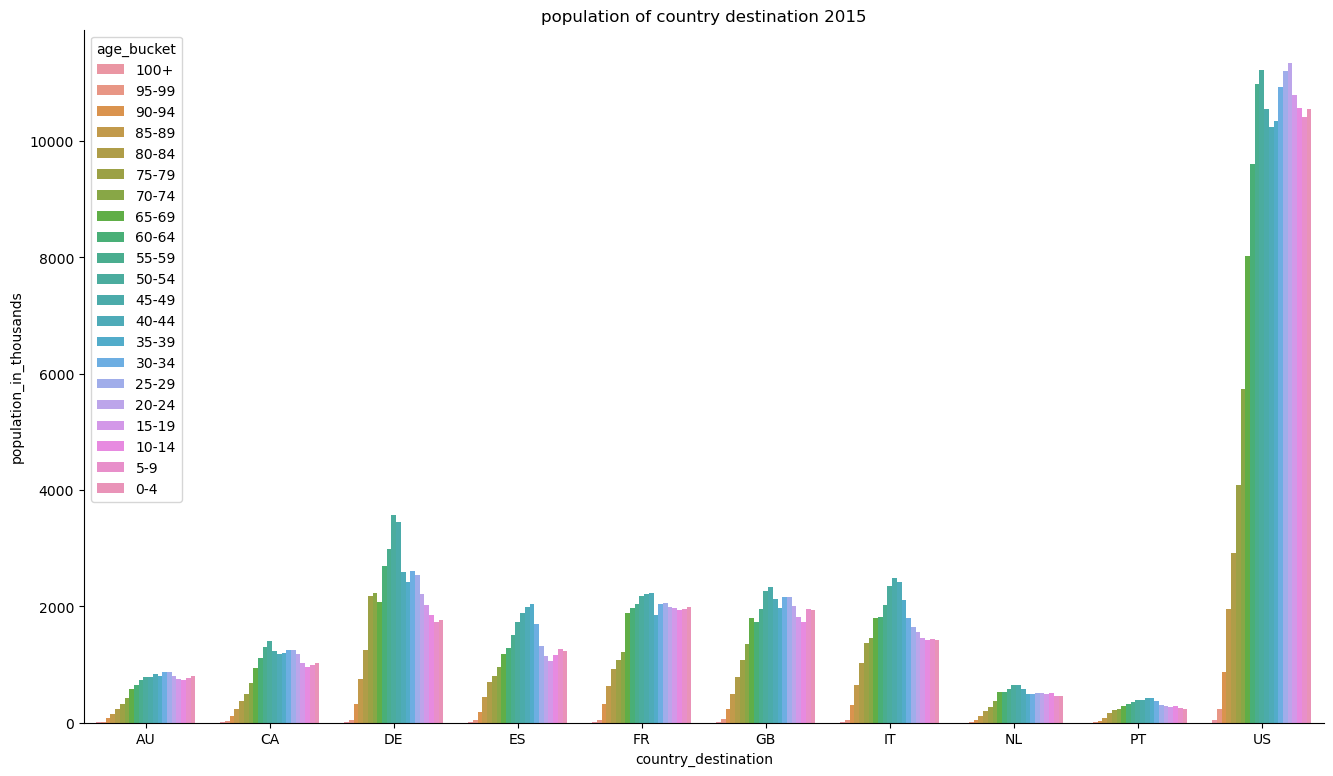

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
sns.barplot(data=df_age_bkts,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## First Device vs Destination Country

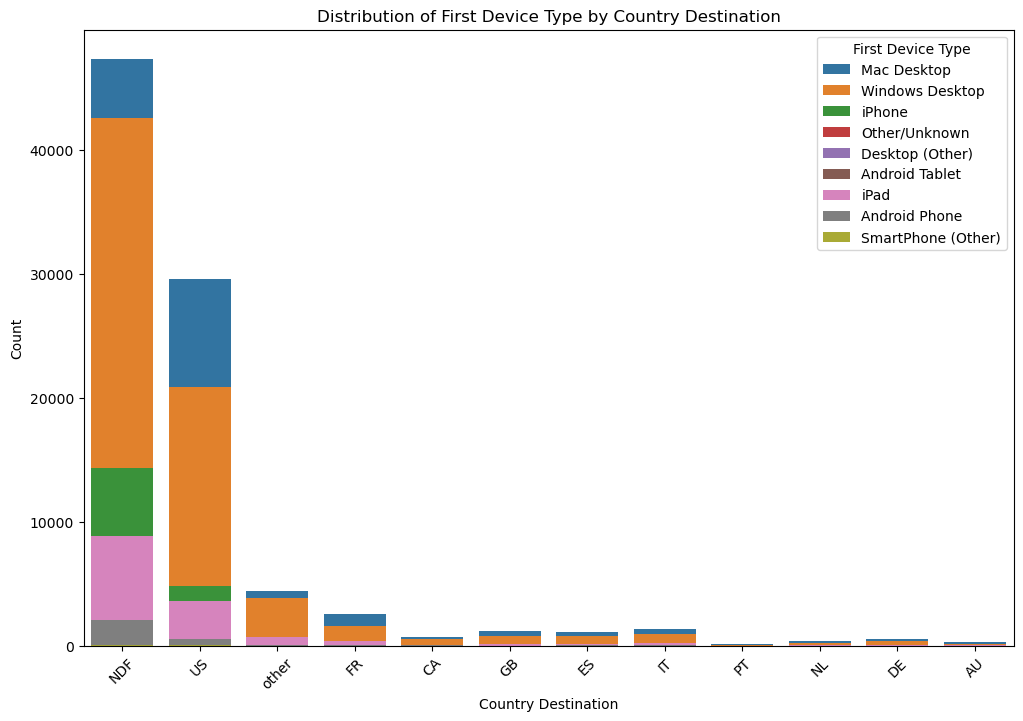

In [ ]:
# Assuming df_train_users is your DataFrame
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=df_airbnb_users, x='country_destination', hue='first_device_type', dodge=False, ax=ax)

ax.set_title('Distribution of First Device Type by Country Destination')
ax.set_ylabel('Count')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type')

plt.show()

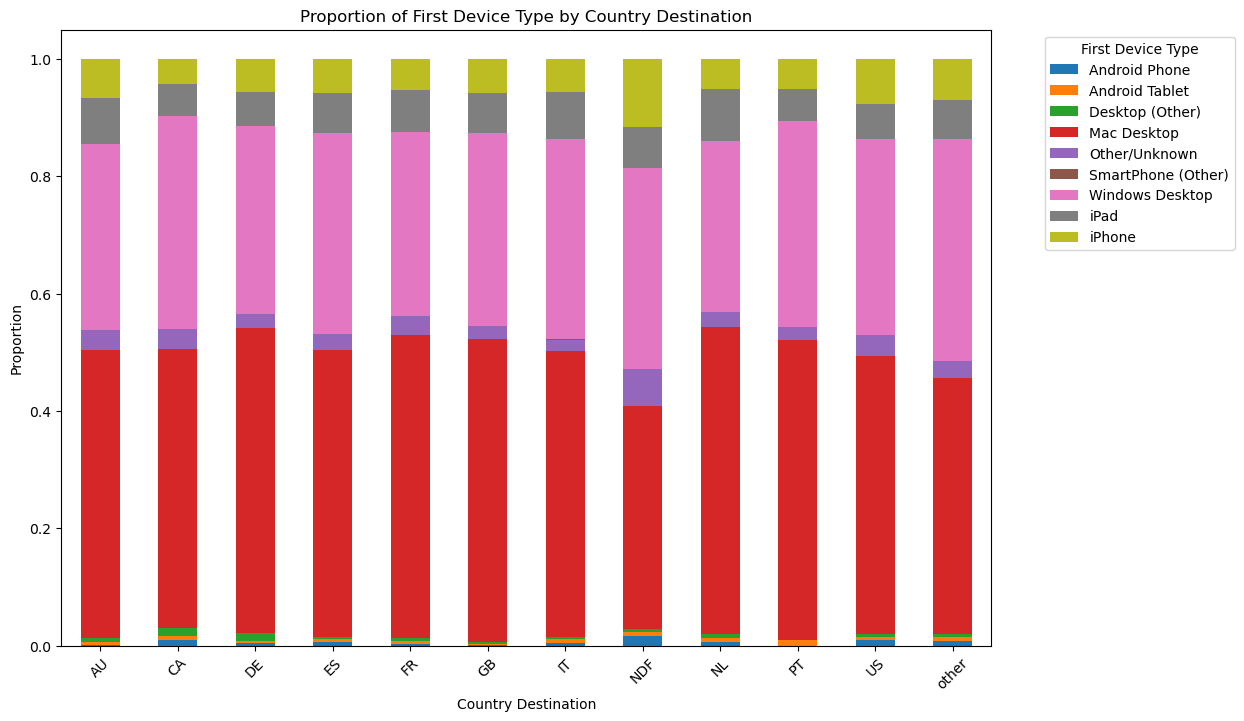

In [ ]:
# Assuming df_train_users is your DataFrame
# Step 1: Calculate proportions
proportions = df_airbnb_users.groupby(['country_destination', 'first_device_type']).size().reset_index(name='count')
total_counts = df_airbnb_users['country_destination'].value_counts().reset_index()
total_counts.columns = ['country_destination', 'total_count']

proportions = proportions.merge(total_counts, on='country_destination')
proportions['proportion'] = proportions['count'] / proportions['total_count']

# Step 2: Create a pivot table
pivot_df = proportions.pivot_table(index='country_destination', columns='first_device_type', values='proportion', fill_value=0)

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Proportion of First Device Type by Country Destination')
ax.set_ylabel('Proportion')
ax.set_xlabel('Country Destination')
plt.xticks(rotation=45)
plt.legend(title='First Device Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<Axes: xlabel='age'>

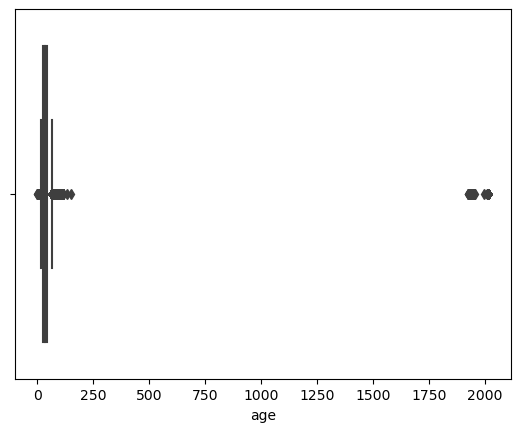

In [ ]:
sns.boxplot(data=df_airbnb_users, x='age')

# Data Cleaning

In [3]:
df_airbnb_cleaned = df_airbnb_users.copy()

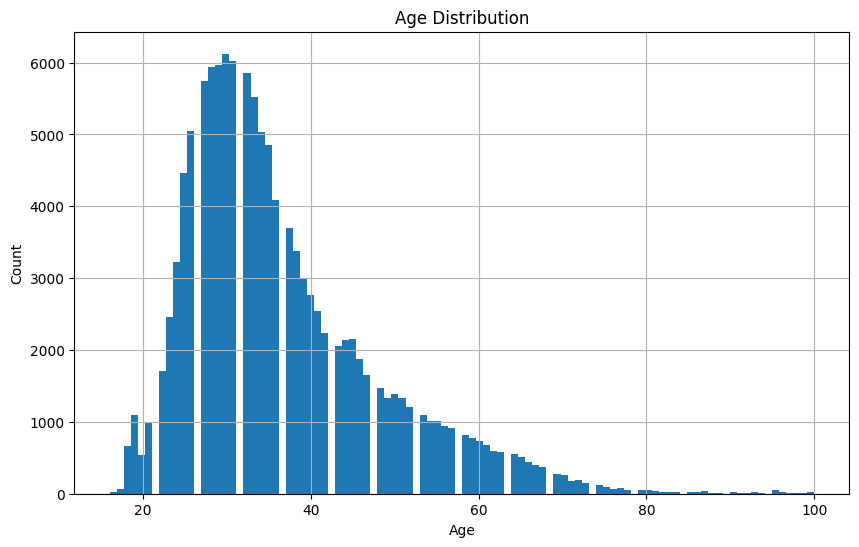

count    123079.000000
mean         36.569236
std          11.703130
min          16.000000
25%          28.000000
50%          34.000000
75%          42.000000
max         100.000000
Name: age, dtype: float64


In [4]:
# Adjust the weird ages. Seems like there are some years added to the age

ages = df_airbnb_cleaned['age'].copy()

ref_year = 2010 # "...users dataset dates back to 2010."
ages[(ages >= 1910) & (ages <= 1994)] = ref_year - ages[(ages >= 1910) & (ages <= 1994)]
ages[(ages < 16) | (ages > 100)] = np.nan

plt.figure(figsize=(10,6))
ages.hist(bins=100)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print(ages.describe())

# replacing orginal age column with cleaned age column
df_airbnb_cleaned['age'] = ages

# Drop Ages < 18, it is AirBnB policy that minimum age of users should be 18

df_airbnb_cleaned = df_airbnb_cleaned[df_airbnb_cleaned['age'] >= 18]

In [5]:
df_airbnb_cleaned.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         55781
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     1960
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [6]:
# Drop NA
df_airbnb_cleaned['first_affiliate_tracked'] = df_airbnb_cleaned['first_affiliate_tracked'].fillna('Unknown')
df_airbnb_cleaned = df_airbnb_users.dropna()
df_airbnb_cleaned.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [7]:
# Calculate the total session time per user ID
total_session_time_per_user = (df_sessions.groupby('user_id')['secs_elapsed'].sum().reset_index())

# Merge the total session time with the df_train using the correct column names
df_airbnb_cleaned = pd.merge(df_airbnb_cleaned, total_session_time_per_user, left_on='id', right_on='user_id', how='left')

# Rename the column to be more descriptive
df_airbnb_cleaned.rename(columns={'secs_elapsed': 'total_session_time'}, inplace=True)

# Drop the redundant 'user_id' column
df_airbnb_cleaned.drop('user_id', axis=1, inplace=True)

# Data Processing and Feature Adjustments

In [8]:
df_airbnb_cleaned.fillna(value={'total_session_time':0}, inplace=True)

In [9]:
def get_month_diff (date, today):
    date = pd.to_datetime(date)
    return (relativedelta(date, today).years * 12 + relativedelta(date, today).months) * -1

today = datetime.today()
df_airbnb_cleaned['account_age_months'] = df_airbnb_cleaned['date_account_created'].apply(lambda date: get_month_diff(date, today))
df_airbnb_cleaned['first_booking_months'] = df_airbnb_cleaned['date_first_booking'].apply(lambda date: get_month_diff(date, today))

df_airbnb_cleaned.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_session_time,account_age_months,first_booking_months
0,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,0.0,164,166
1,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0.0,150,141
2,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,0.0,165,172
3,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US,0.0,173,173
4,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US,0.0,173,173


# Feature Importance and Correlation

In [ ]:
#Extract numerical and categorical columns

categorical_features = df_airbnb_cleaned.select_dtypes(include=['object','category']).columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_indices = [df_airbnb_cleaned.columns.get_loc(col) for col in categorical_features]

In [11]:
# Perform ANOVA test to find associal between numerical features and country_destination

destinations = df_airbnb_cleaned['country_destination'].unique()

for numerical_feature in numeric_features:
    arrays = [df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == country][numerical_feature] for country in destinations]
    f_stat, p_value = f_oneway(*arrays)
    print(f'ANOVA F-statistic for feature {numerical_feature}: {f_stat}, p-value: {p_value}')

ANOVA F-statistic for feature timestamp_first_active: 20.08651427801075, p-value: 1.2206801464135887e-37
ANOVA F-statistic for feature age: 0.48992801559333016, p-value: 0.8977965530601025
ANOVA F-statistic for feature signup_flow: 12.086432562141015, p-value: 3.54008214760169e-21
ANOVA F-statistic for feature total_session_time: 3.995450352465104, p-value: 1.732581440225828e-05
ANOVA F-statistic for feature account_age_months: 26.365241275455098, p-value: 9.237252733760934e-51
ANOVA F-statistic for feature first_booking_months: 31.25707692177085, p-value: 4.7874292491202205e-61


Cramers_V Interpretation Scale
* 0.00 to 0.10: Negligible association
* 0.10 to 0.20: Weak association
* 0.20 to 0.40: Moderate association
* 0.40 to 0.60: Relatively strong association
* 0.60 to 0.80: Strong association
* 0.80 to 1.00: Very strong association

In [12]:
# Explore how the activity is correlated with all the other variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for categorical_feature in categorical_features:
    cramers_v_result = cramers_v(df_airbnb_cleaned['country_destination'], df_airbnb_cleaned[categorical_feature])
    print(f"Cramers_V output for feature {categorical_feature} = {cramers_v_result}")

<ipython-input-12-baad2157903a>:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Cramers_V output for feature id = inf
Cramers_V output for feature date_account_created = 0.04163208387799076
Cramers_V output for feature date_first_booking = 0.053403217413453045
Cramers_V output for feature gender = 0.03226014432807613
Cramers_V output for feature signup_method = 0.012151460393875553
Cramers_V output for feature language = 0.021124698432408825
Cramers_V output for feature affiliate_channel = 0.029262149791984726
Cramers_V output for feature affiliate_provider = 0.020463733939257458
Cramers_V output for feature first_affiliate_tracked = 0.015832562305249983
Cramers_V output for feature signup_app = 0.030688821460577383
Cramers_V output for feature first_device_type = 0.02214870711934843
Cramers_V output for feature first_browser = 0.007699147095242534
Cramers_V output for feature country_destination = 1.0


In [13]:
# Drop ID, Date_Account_Created, Date_First_Booking
df_airbnb_cleaned = df_airbnb_cleaned.drop(columns=['id', 'date_account_created','date_first_booking', 'timestamp_first_active'])

#Extract numerical and categorical columns again

categorical_features = df_airbnb_cleaned.select_dtypes(include=['object','category']).columns
numeric_features = df_airbnb_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_indices = [df_airbnb_cleaned.columns.get_loc(col) for col in categorical_features]

In [14]:
# Separate features and target
X = df_airbnb_cleaned.drop('country_destination', axis=1)
y = df_airbnb_cleaned['country_destination']

# Step 1: Undersample the majority class ('US')
df_us = df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] == 'US']
df_other = df_airbnb_cleaned[df_airbnb_cleaned['country_destination'] != 'US']

# Undersample "US" to match the count of the second most frequent class
df_us_under = resample(df_us, replace=False, n_samples=max(df_other['country_destination'].value_counts()), random_state=42)

# Combine undersampled "US" with the minority classes
df_balanced = pd.concat([df_us_under, df_other])

# Separate features and target variable
X_balanced = df_balanced.drop('country_destination', axis=1)
y_balanced = df_balanced['country_destination']

# Step 2: Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_balanced, y_balanced)

# Print value counts of the target variable after oversampling
print(pd.Series(y_resampled).value_counts())

US       7557
other    7557
CA       7557
FR       7557
IT       7557
ES       7557
GB       7557
NL       7557
DE       7557
AU       7557
PT       7557
Name: country_destination, dtype: int64


# Test-Train Split

In [15]:
# Perform train-test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#Extract numerical and categorical columns again

categorical_features = X_train.select_dtypes(include=['object','category']).columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [16]:
# Select only the categorical columns from the training and testing data
X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numeric_features]
X_test_categorical = X_test[categorical_features]
X_test_numerical = X_test[numeric_features]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical features in the training data
X_train_categorical_encoded = encoder.fit_transform(X_train_categorical)

# Transform the categorical features in the testing data
X_test_categorical_encoded = encoder.transform(X_test_categorical)

# Convert sparse matrices to DataFrames
X_train_categorical_df = pd.DataFrame(X_train_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(input_features=categorical_features))
X_test_categorical_df = pd.DataFrame(X_test_categorical_encoded.toarray(), columns=encoder.get_feature_names_out(input_features=categorical_features))

X_train_numerical.reset_index(drop=True, inplace=True)
X_test_numerical.reset_index(drop=True, inplace=True)

# Concatenate DataFrames along axis=1 (horizontally) with the numerical features
X_train_encoded = pd.concat([X_train_categorical_df, X_train_numerical], axis=1)
X_test_encoded = pd.concat([X_test_categorical_df, X_test_numerical], axis=1)

# Modeling

## Supervised Classifiers and Ensembles

### Random Forest

In [17]:
rf=RandomForestClassifier()

rf.fit(X_train_encoded,y_train)
target_names = ['US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU']
y_pred_rf=rf.predict(X_test_encoded)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

          US       0.75      0.80      0.77      1558
       other       0.65      0.69      0.67      1513
          FR       0.66      0.73      0.69      1483
          CA       0.57      0.61      0.59      1482
          GB       0.47      0.41      0.44      1506
          ES       0.60      0.59      0.59      1555
          IT       0.58      0.54      0.56      1576
          PT       0.70      0.77      0.73      1474
          NL       0.79      0.85      0.82      1475
          DE       0.25      0.22      0.23      1500
          AU       0.27      0.22      0.24      1504

    accuracy                           0.59     16626
   macro avg       0.57      0.59      0.58     16626
weighted avg       0.57      0.59      0.58     16626



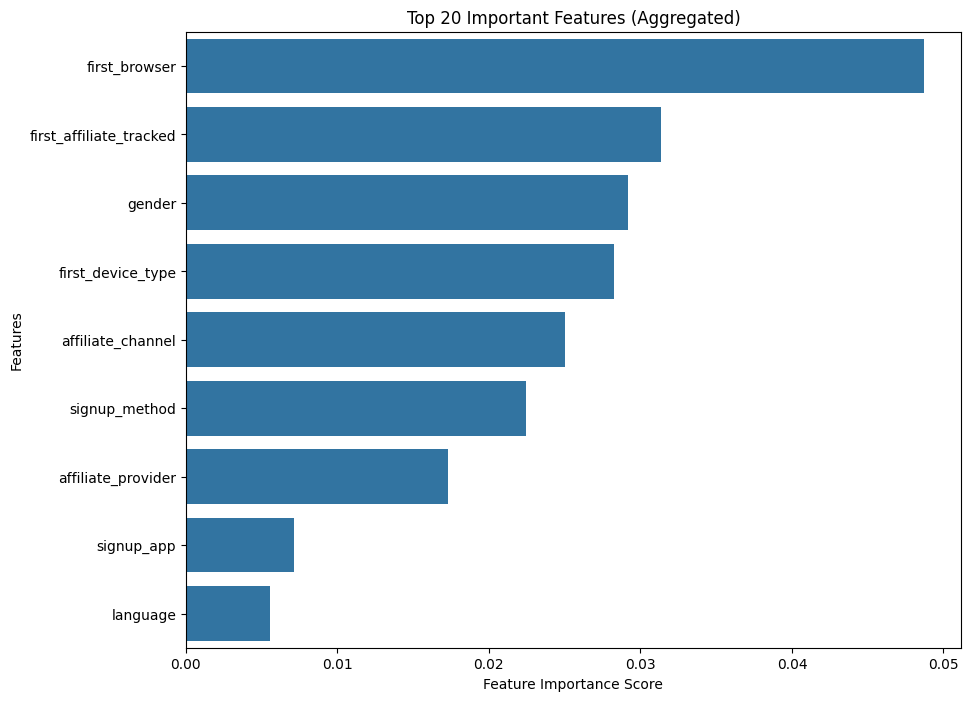

In [18]:
# Used chatGPT for this :

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

feature_names=list(X_train_encoded.columns.values.tolist())
feature_imp = pd.Series(rf.feature_importances_,index=feature_names).sort_values(ascending=False)

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()



### XGBoost

In [19]:
# Lots of ChatGPT help here. Apparently it's not easy to go from categoricals to one_hot_encoding for XGBoost directly for y (Target)
# Need to first convert to label encodings and then one hot

# Initialize LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Convert y_train and y_test to NumPy arrays
y_train_array = y_train.values
y_test_array = y_test.values

# Encode y_train with LabelEncoder
y_train_labels = label_encoder.fit_transform(y_train_array)

# Reshape y_train_labels to be 2D and apply OneHotEncoder
y_train_reshaped = y_train_labels.reshape(-1, 1)
y_train_encoded = one_hot_encoder.fit_transform(y_train_reshaped)

# Train the model
xgb = XGBClassifier()
xgb.fit(X_train_encoded, y_train_encoded)

# Predict using the model
y_pred_xgb_encoded = xgb.predict(X_test_encoded)

# Decode predictions to original label format using LabelEncoder
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded.argmax(axis=1))

# Print classification report
print(classification_report(y_test_array, y_pred_xgb, target_names=target_names))

              precision    recall  f1-score   support

          US       0.11      0.98      0.20      1558
       other       0.86      0.17      0.29      1513
          FR       0.81      0.17      0.29      1483
          CA       0.77      0.08      0.14      1482
          GB       0.56      0.03      0.06      1506
          ES       0.80      0.06      0.12      1555
          IT       0.71      0.07      0.13      1576
          PT       0.87      0.26      0.40      1474
          NL       0.89      0.64      0.75      1475
          DE       0.40      0.04      0.07      1500
          AU       0.38      0.04      0.07      1504

    accuracy                           0.23     16626
   macro avg       0.65      0.23      0.23     16626
weighted avg       0.65      0.23      0.23     16626



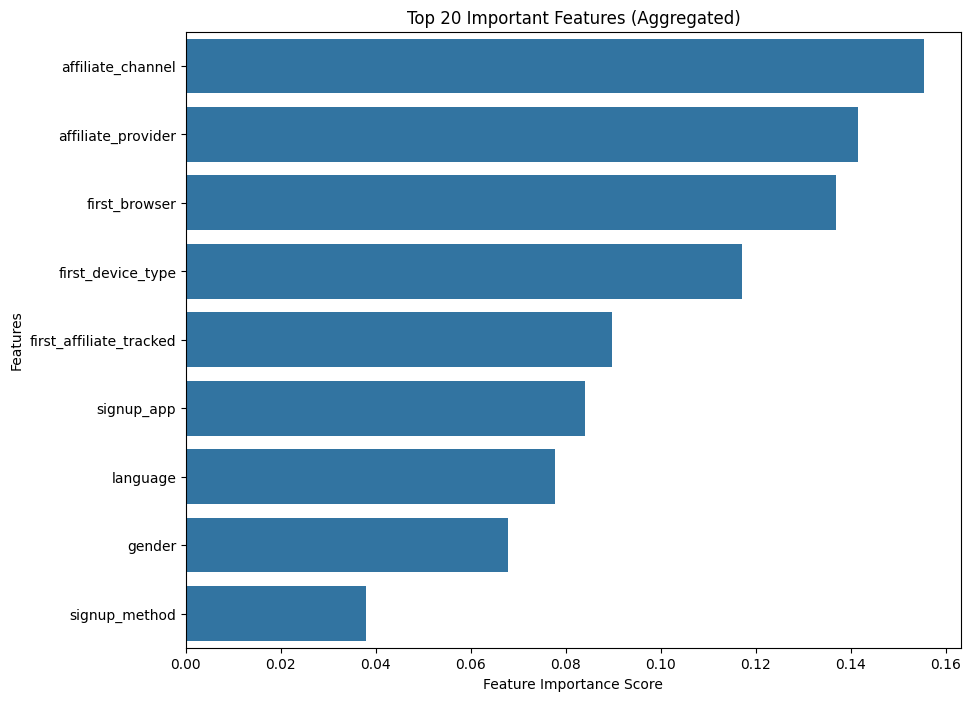

In [20]:
# Used chatGPT for this :

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

feature_names=list(X_train_encoded.columns.values.tolist())
feature_imp = pd.Series(xgb.feature_importances_,index=feature_names).sort_values(ascending=False)

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()



### CatBoost

In [22]:
!pip3 install catboost
from catboost import CatBoostClassifier

catboost = CatBoostClassifier()
catboost.fit(X_train_encoded, y_train)

y_pred_catboost = catboost.predict(X_test_encoded)

print(classification_report(y_test, y_pred_catboost))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.5 MB/s eta 0:00:00
Learning rate set to 0.098014
0:	learn: 2.3834669	total: 240ms	remaining: 3m 59s
1:	learn: 2.3708548	total: 425ms	remaining: 3m 32s
2:	learn: 2.3592927	total: 605ms	remaining: 3m 21s
3:	learn: 2.3498995	total: 778ms	remaining: 3m 13s
4:	learn: 2.3416775	total: 966ms	remaining: 3m 12s
5:	learn: 2.3340394	total: 1.16s	remaining: 3m 11s
6:	learn: 2.3281404	total: 1.34s	remaining: 3m 10s
7:	learn: 2.3174035	total: 1.52s	remaining: 3m 8s
8:	learn: 2.3121880	total: 1.7s	remaining: 3m 7s
9:	learn: 2.3029158	total: 1.88s	remaining: 3m 5s
10:	learn: 2.2979157	total: 2.08s	remaining: 3m 7s
11:	learn: 2.2944208	total: 2.26s	remaining: 3m 6s
12:	learn: 2.2903739	total: 2.45s	remaining: 3m 5s
13:	learn: 2.2863082	total: 2.63s	remaining: 3m 4s
14:	learn: 2.2823670	total: 2.81s	remaining: 3m 4s
15:	learn: 2.2786581	total: 2.99s	remaining: 3m 3s
16:	learn: 2.2694164	total: 3.18s	remaining: 3m 4s
17:	learn: 2.2669824	total:

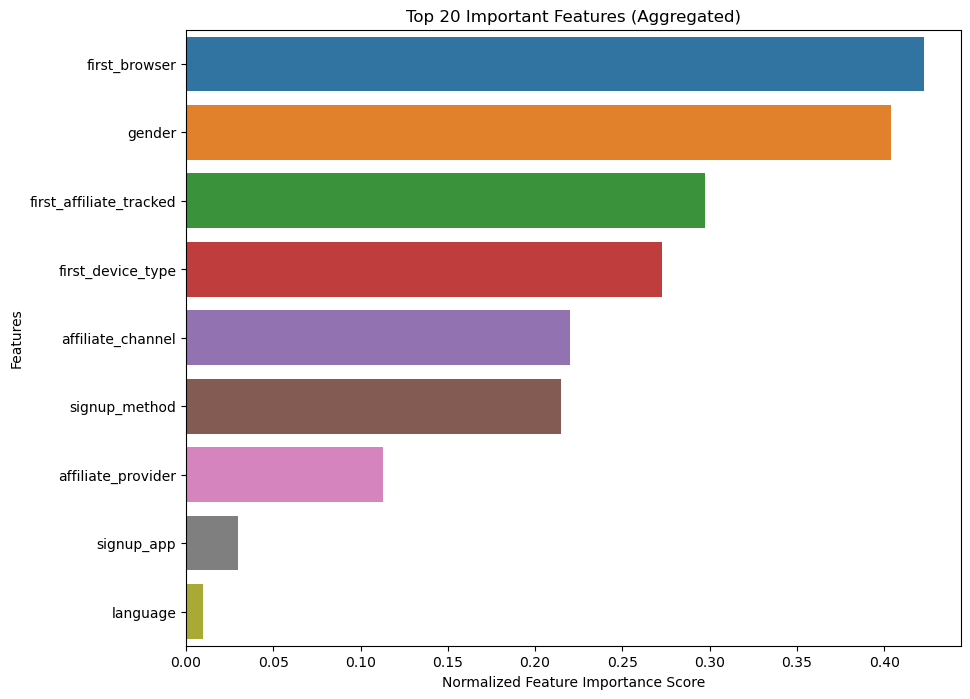

In [ ]:
# Extract feature importances
feature_imp = pd.Series(catboost.get_feature_importance(), index=X_train_encoded.columns).sort_values(ascending=False)

# Normalize the feature importances to be between 0 and 1
normalized_feature_imp = feature_imp / feature_imp.max()

# Initialize an empty dictionary to store aggregated feature importances
aggregated_feature_importance = {}

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = normalized_feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_feature_importance_series = pd.Series(aggregated_feature_importance)

# Sort the aggregated feature importance Series
aggregated_feature_importance_series_sorted = aggregated_feature_importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_feature_importance_series_sorted[:20], y=aggregated_feature_importance_series_sorted.index[:20])
plt.xlabel('Normalized Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Aggregated)")
plt.show()


### Voting Ensemble

In [23]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train_array)

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xg', xgb), ('cb', catboost)], voting='soft')

# Fit the ensemble model using the encoded target labels
ensemble_model.fit(X_train_encoded, y_train_encoded)

# Make predictions
y_pred_encoded = ensemble_model.predict(X_test_encoded)

# Decode predictions to original label format using LabelEncoder
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test_array, y_pred, target_names=target_names))

Learning rate set to 0.098014
0:	learn: 2.3834669	total: 201ms	remaining: 3m 20s
1:	learn: 2.3708548	total: 378ms	remaining: 3m 8s
2:	learn: 2.3592927	total: 584ms	remaining: 3m 14s
3:	learn: 2.3498995	total: 763ms	remaining: 3m 9s
4:	learn: 2.3416775	total: 948ms	remaining: 3m 8s
5:	learn: 2.3340394	total: 1.13s	remaining: 3m 6s
6:	learn: 2.3281404	total: 1.31s	remaining: 3m 5s
7:	learn: 2.3174035	total: 1.5s	remaining: 3m 6s
8:	learn: 2.3121880	total: 1.69s	remaining: 3m 6s
9:	learn: 2.3029158	total: 1.87s	remaining: 3m 5s
10:	learn: 2.2979157	total: 2.06s	remaining: 3m 5s
11:	learn: 2.2944208	total: 2.23s	remaining: 3m 3s
12:	learn: 2.2903739	total: 2.42s	remaining: 3m 3s
13:	learn: 2.2863082	total: 2.61s	remaining: 3m 3s
14:	learn: 2.2823670	total: 2.79s	remaining: 3m 3s
15:	learn: 2.2786581	total: 2.98s	remaining: 3m 3s
16:	learn: 2.2694164	total: 3.17s	remaining: 3m 3s
17:	learn: 2.2669824	total: 3.35s	remaining: 3m 2s
18:	learn: 2.2614966	total: 3.56s	remaining: 3m 3s
19:	learn:

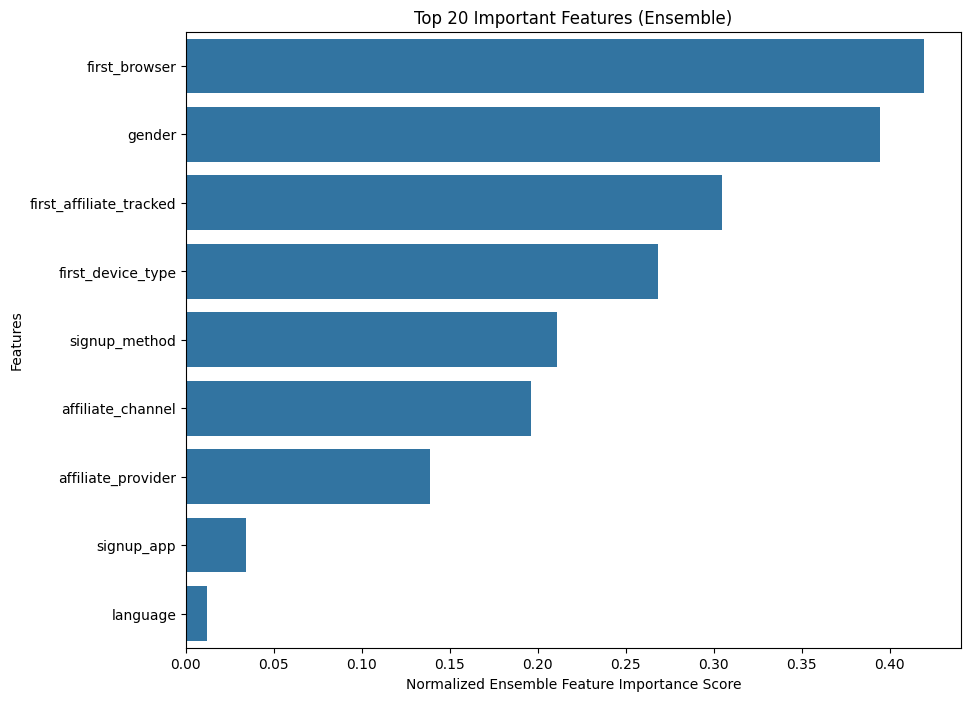

In [27]:

# Extract feature importances for each model in the ensemble
rf_feature_imp = pd.Series(rf.feature_importances_, index=X_train_encoded.columns)
xgb_feature_imp = pd.Series(xgb.feature_importances_, index=X_train_encoded.columns)
cb_feature_imp = pd.Series(catboost.get_feature_importance(), index=X_train_encoded.columns)

# Calculate the average feature importance across all models
ensemble_feature_imp = (rf_feature_imp + xgb_feature_imp + cb_feature_imp) / 3

# Normalize the feature importances to be between 0 and 1
normalized_ensemble_feature_imp = ensemble_feature_imp / ensemble_feature_imp.max()

# Initialize an empty dictionary to store aggregated feature importances
aggregated_ensemble_feature_importance = {}

# Loop through each original categorical feature
for feature in categorical_features:
    # Find all one-hot encoded columns corresponding to this categorical feature
    one_hot_columns = [col for col in X_train_encoded.columns if col.startswith(feature)]
    # Sum the feature importances of these one-hot encoded columns
    total_importance = normalized_ensemble_feature_imp[one_hot_columns].sum()
    # Store the aggregated importance under the original feature name
    aggregated_ensemble_feature_importance[feature] = total_importance

# Convert the aggregated feature importance dictionary to a pandas Series
aggregated_ensemble_feature_imp_series = pd.Series(aggregated_ensemble_feature_importance)

# Sort the aggregated feature importance Series
aggregated_ensemble_feature_imp_series_sorted = aggregated_ensemble_feature_imp_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=aggregated_ensemble_feature_imp_series_sorted[:20], y=aggregated_ensemble_feature_imp_series_sorted.index[:20])
plt.xlabel('Normalized Ensemble Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 20 Important Features (Ensemble)")
plt.show()


<ipython-input-29-fddde0e99a77>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_scores, palette='Set3')


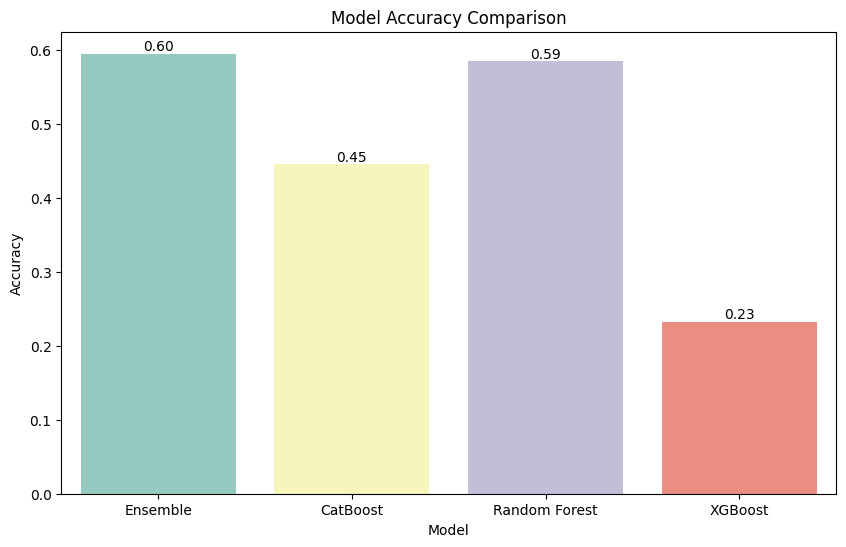

In [29]:
# List of model names
model_names = ['Ensemble', 'CatBoost', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_catboost), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)]

# Create a bar chart showing accuracy score comparisons
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette='Set3')

# Add accuracy scores above each bar
for i in range(len(model_names)):
  plt.text(i, accuracy_scores[i], f'{accuracy_scores[i]:.2f}', ha='center', va='bottom')

plt.title('Accuracy Score Comparison')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

plt.show()


## K-Means

In [ ]:
df_kmeans_train = X_train.copy()

In [ ]:
# Scale the numerical columns data for k-means clustering
numeric_features = df_kmeans_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()

# Apply StandardScaler to numerical columns
df_kmeans_train[numeric_features] = scaler.fit_transform(df_kmeans_train[numeric_features])

# One Hot Encode
categorical_features = df_kmeans_train.select_dtypes(include='object').columns

df_kmeans_encoded = pd.get_dummies(df_kmeans_train, columns=categorical_features, drop_first=True)
display(df_kmeans_encoded.info())

display(df_kmeans_encoded.dtypes)

# Use PCA to reduce dimensionality

pca = PCA(0.95)
df_kmeans_pca = pca.fit_transform(df_kmeans_encoded)

# Just naming cleanliness ;)
df_kmeans_train = df_kmeans_pca

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 11343 to 15795
Data columns (total 97 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   timestamp_first_active                  66501 non-null  float64
 1   age                                     66501 non-null  float64
 2   signup_flow                             66501 non-null  float64
 3   total_session_time                      66501 non-null  float64
 4   account_age_months                      66501 non-null  float64
 5   first_booking_months                    66501 non-null  float64
 6   gender_FEMALE                           66501 non-null  uint8  
 7   gender_MALE                             66501 non-null  uint8  
 8   gender_OTHER                            66501 non-null  uint8  
 9   signup_method_facebook                  66501 non-null  uint8  
 10  signup_method_google                    66501 non-null

None

timestamp_first_active            float64
age                               float64
signup_flow                       float64
total_session_time                float64
account_age_months                float64
                                   ...   
first_browser_Sogou Explorer        uint8
first_browser_Stainless             uint8
first_browser_TenFourFox            uint8
first_browser_TheWorld Browser      uint8
first_browser_Yandex.Browser        uint8
Length: 97, dtype: object

In [ ]:
def kmeans_execution(df, num_clusters):
    # Create models & store labels for different number of clusters
    model = KMeans(n_clusters = num_clusters, n_init='auto', random_state = 0) # Create KMeans object \
    #kmeans = MiniBatchKMeans(n_clusters=k, random_state=716, batch_size=1000)
    model.fit(df) # Apply to the data
    labels = model.labels_ # Capture K-Means labels
    distortion = model.inertia_ # Used for elbow method
    silhouette = silhouette_score(df, labels)
    centers = model.cluster_centers_
    return {
        'model' : model,
        'centers' : centers,
        'labels' : labels,
        'distortion' : distortion,
        'silhouette_score' : silhouette
    }

k_means_cluster_results = {}
num_clusters_range = range(3, 13)

for cluster in num_clusters_range:
    k_means_cluster_results[cluster] = kmeans_execution(df_kmeans_train, cluster)
    print(f"Silhouette score for {cluster} clusters = {k_means_cluster_results[cluster]['silhouette_score']}")

Silhouette score for 3 clusters = 0.27693646553990253
Silhouette score for 4 clusters = 0.17484709085465963
Silhouette score for 5 clusters = 0.19703261217473553
Silhouette score for 6 clusters = 0.1748282667177392
Silhouette score for 7 clusters = 0.1832690305433862
Silhouette score for 8 clusters = 0.17055390559718978
Silhouette score for 9 clusters = 0.17830852579654097
Silhouette score for 10 clusters = 0.17395497870257864
Silhouette score for 11 clusters = 0.16236951999030066
Silhouette score for 12 clusters = 0.16749837123768083


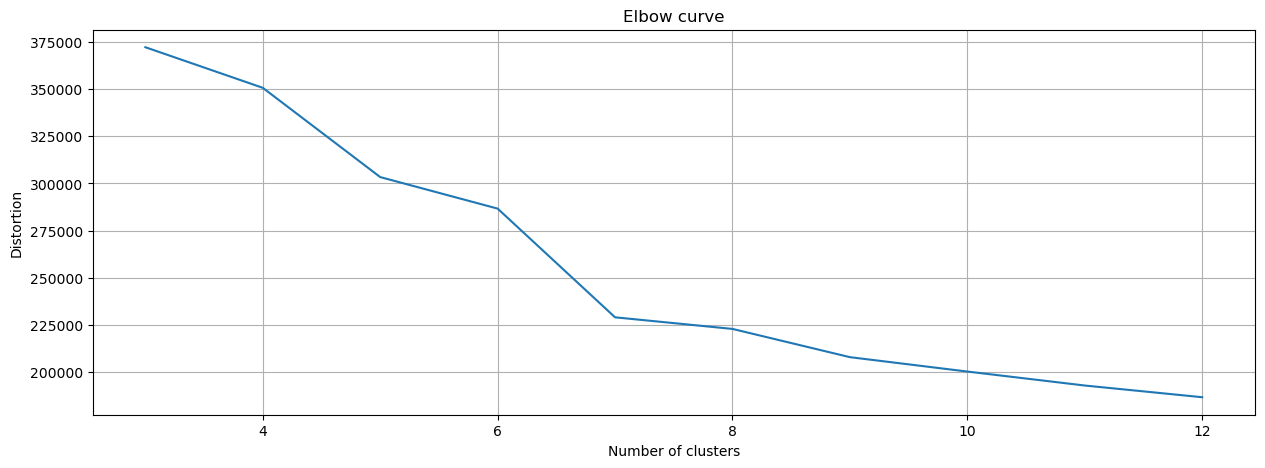

In [ ]:
# Extracting distortions for different k values
distortions = [k_means_cluster_results[cluster]['distortion'] for cluster in num_clusters_range]

fig = plt.figure(figsize=(15, 5))
plt.plot(num_clusters_range, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

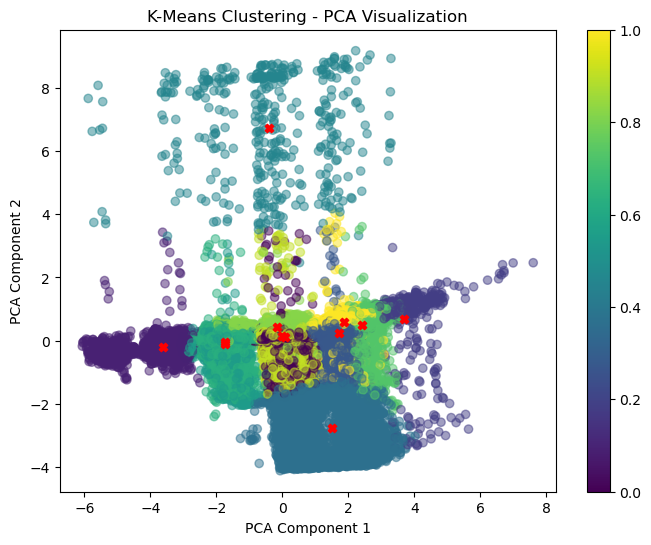

In [ ]:
# Visualize clusters in PCA space
ideal_cluster_size = 12

plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_train[:, 0], df_kmeans_train[:, 1], c=k_means_cluster_results[ideal_cluster_size]['labels'], cmap='viridis', alpha=0.5, label='Data points')
plt.scatter(k_means_cluster_results[ideal_cluster_size]['centers'][:,0], k_means_cluster_results[ideal_cluster_size]['centers'][:,1], c='red', marker='X', label='Cluster Centers')
plt.title('K-Means Clustering - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()